In [77]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import yfinance as yf
from fastai.tabular.all import add_datepart

In [78]:
ticker = 'CL=F' # stock ticker symbol: WTI Crude Oil
period = 'max' # time range to look at: all time
interval = '1d' # time interval for data collected: daily
search = 'Low' # Low, High, Open, Close, Volume

In [ ]:
H = 21 # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3 # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252 # Use 1 year of data as validation set
N = 10 # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100 # Number of boosted trees to fit. default = 100
max_depth = 3 # Maximum tree depth for base learners. default = 3
learning_rate = 0.1 # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1 # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1 # Subsample ratio of the training instance. default = 1
colsample_bytree = 1 # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1 # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0 # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 1

In [ ]:
train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

In [79]:
def get_hist(tck, srch, time='Max', ivl='1d'):
    tick = yf.Ticker(tck)
    df = tick.history(period=time, interval=ivl, back_adjust=True)

    df = df[[srch]]

    # reformat data
    df = df.loc[::-1]
    df = df.reset_index()

    # add date data
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    # gets rid of datetime values
    df = df.drop('Date', axis=1)

    # start of year is never a trading day so removed
    df = df.drop(columns='Is_year_start')

    return df

In [80]:
# get historic data
# df = get_hist(ticker, period, interval, search)
# df.to_csv(f'data.csv', index=False)

In [81]:
df = pd.read_csv('data.csv')

In [96]:
df

,Low,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end
0,73.099998,2023,2,5,3,4,34,False,False,False,False,False
1,74.970001,2023,2,5,2,3,33,False,False,False,False,False
2,76.050003,2023,2,5,1,2,32,False,True,False,False,False
3,76.550003,2023,1,5,31,1,31,True,False,False,False,False
4,77.660004,2023,1,5,30,0,30,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5634,32.560001,2000,8,35,29,1,242,False,False,False,False,False
5635,31.860001,2000,8,35,28,0,241,False,False,False,False,False
5636,31.320000,2000,8,34,25,4,238,False,False,False,False,False
5637,31.400000,2000,8,34,24,3,237,False,False,False,False,False


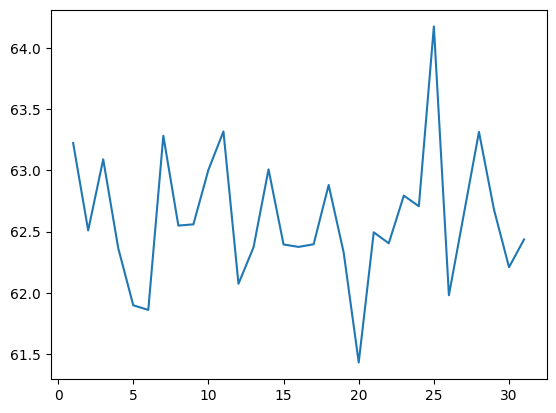

In [82]:
s = df.groupby(['Day'])[search].mean()
plt.plot(s.index, s.values)
plt.show()

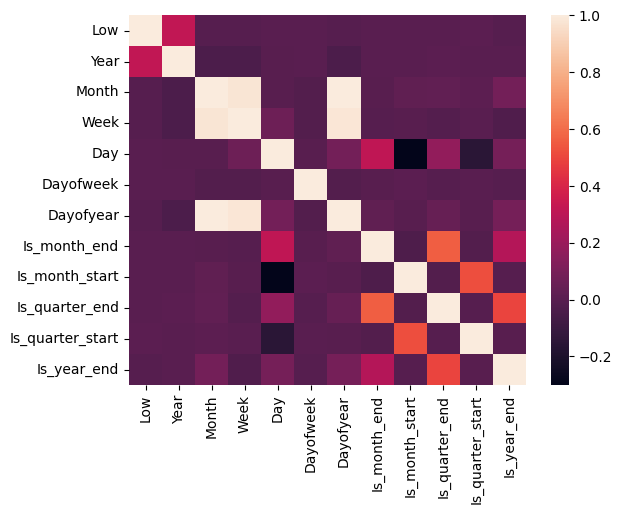

In [83]:
dataplot = sb.heatmap(df.corr())
plt.show()

In [84]:
# create test set of last year of data
test = df.drop(df.tail(df.shape[0]-365).index, inplace = False)
train = df

In [85]:
y_train = train[search]
X_train = train.drop(columns=search)
y_test = test[search]
X_test = test.drop(columns=search)

In [86]:
train_dmatrix = xg.DMatrix(data=X_train, label=y_train)
test_dmatrix = xg.DMatrix(data=X_test, label=y_test)

In [87]:
# dates = {
#     'year':[],
#     'month':[],
#     'day':[]
# }
# for i in range(5):
#     dates['year'] += [2023]
#     dates['month'] += [1]
#     dates['day'] += [25+i]
# future = pd.DataFrame.from_dict(dates)
# future

In [88]:
# Instantiation
model = xg.XGBRegressor(objective='reg:squarederror', n_estimators=13, predictor='gpu_predictor')

In [89]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=13, n_jobs=None, num_parallel_tree=None,
             predictor='gpu_predictor', random_state=None, ...)

In [90]:
# Predict the model
yhat = model.predict(X_test)

In [91]:
# X_test['Year'], X_test['Month'], X_test['Day']

In [92]:
print(len(yhat))
print(yhat[0])
print(y_test[0])

365
76.91658
73.0999984741211


In [93]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  3.568192


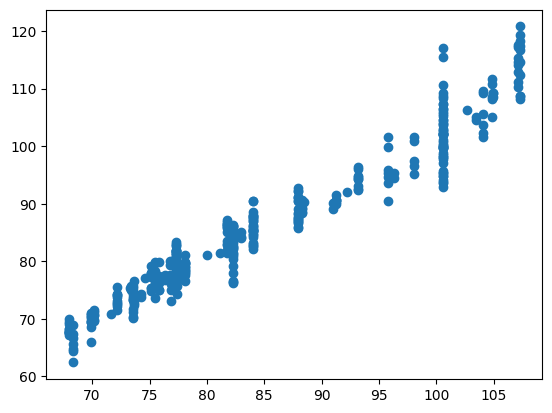

In [94]:
plt.scatter(yhat, y_test)
plt.show()

In [95]:
# todo:
# search prices of the last N=10 days as feature columns
# setup a prediction view method
# predict future
# run daily
